# Library Imports and Data Loading

In [1]:
%%capture
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from datetime import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import json
from fbprophet.serialize import model_to_json, model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

#from .autonotebook import tqdm as notebook_tqdm

# 1. Data Loading and Cleaning

In [2]:
# Load dataset 
customer_data = pd.read_csv("data.csv")
customer_data['Date']=pd.to_datetime(customer_data['Date'].astype(str))
customer_data.head()

,Date,Customer,Total
0,2020-01-01,aea36f18ab8d7887628db66b6635d59ba348c4843e9519...,2.0
1,2020-01-01,0b5687f202fcf98d01c9bd071996b3f8066f70b4e16a49...,5.0
2,2020-01-01,fd7182047b43bfd58dcd1c9ccc55c889c9e862f89127df...,6.0
3,2020-01-01,58873afabbba45d3ee3b67e013f1f2be1b5a894f554ae6...,6.0
4,2020-01-01,a302152f779f5db64b74e2258525687738e050a704754f...,20.0


In [3]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17852 entries, 0 to 17851
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      17852 non-null  datetime64[ns]
 1   Customer  17852 non-null  object        
 2   Total     17850 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 418.5+ KB


In [4]:
# Check Date Ranges

max_date = customer_data.Date.max()
min_date = customer_data.Date.min()

print("date range is "+ str(min_date) + " to " + str(max_date) )

date range is 2020-01-01 00:00:00 to 2021-11-30 00:00:00


In [5]:
# check for missing values in the data

customer_data.isna().sum()

Date        0
Customer    0
Total       2
dtype: int64

Two totals have null values. However, the format of the Date data before October is wrong, so we will filter it so that we have hourly data and each day separately for time-series prediction

In [6]:
filt_df = customer_data[customer_data["Date"]>"2020-10-1"]
filt_df.head()

,Date,Customer,Total
7124,2020-10-02,38c5631f75f417c95a0e97030afd28c8f288c7b4374966...,10.0
7125,2020-10-02,81b607a557c523818fcf1cc6c50906100b9183909824d1...,28.0
7126,2020-10-02,6fdff8dc51564fbf547a371a29f522f9ffaa0f80ee4882...,17.0
7127,2020-10-02,fc57fa8ff93fb619f89228dfd8d1263249bcb60cae872c...,7.0
7128,2020-10-02,c93221b886c834753b1ca03b1984987b14f9e844043e7d...,29.0


In [7]:
# Check the null Values again

filt_df.isna().sum()

Date        0
Customer    0
Total       0
dtype: int64

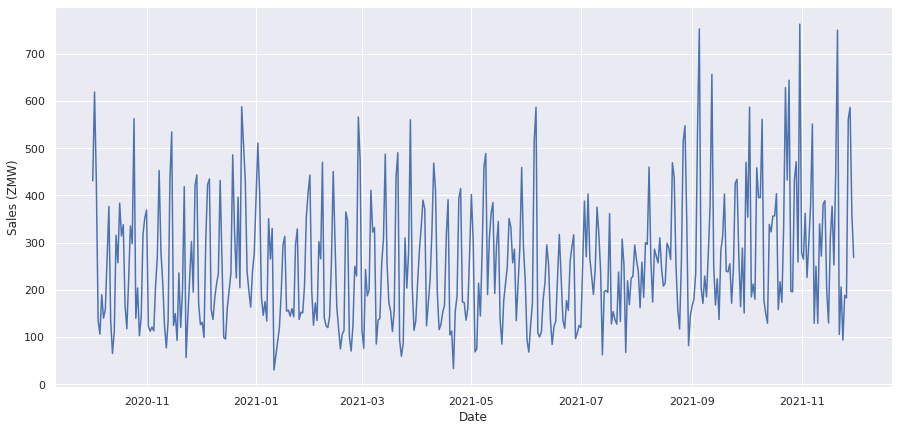

In [8]:
grouped_day = filt_df.groupby("Date", as_index = False).sum()
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=grouped_day,x="Date", y="Total")
plt.ylabel("Sales (ZMW)")
plt.savefig("images/time_plot.png")

/tmp/ipykernel_498/2028267298.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolling = grouped_day[1:].rolling(7).mean()


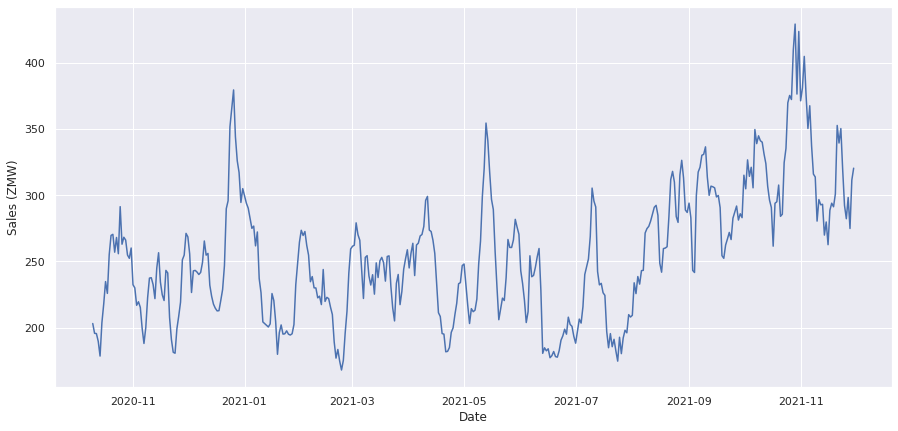

In [9]:
#plot the 7 day rolling average
sns.set()
rolling = grouped_day[1:].rolling(7).mean()
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=rolling[7:],x=grouped_day[8:].Date, y=rolling[7:].Total)
plt.ylabel("Sales (ZMW)")
plt.savefig("images/rolling_time.png")

# 2. Forecasting With Prophet

reference: https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a

In [12]:
# create timeseries readable by fbprophet

ts = pd.DataFrame({'ds':grouped_day.Date,'y':grouped_day.Total})
ts.head()

,ds,y
0,2020-10-02,431.0
1,2020-10-03,619.0
2,2020-10-04,428.3
3,2020-10-05,135.0
4,2020-10-06,106.0


In [10]:
# functions to change time-series to stationary -- currently not used 

def difference(dataset):
	dataset = dataset.copy()
	dataset["y"] = dataset["y"].diff(1)
	return dataset[1:]

# invert differenced forecast
def inverse_difference(shifted_dataset, initial_df):
	shifted_dataset = shifted_dataset.copy()
	initial_df = initial_df.copy()
	shifted_dataset["y"] =  initial_df['y'].shift(1) + 	shifted_dataset['y']
	return shifted_dataset

# invert differenced forecast
def inverse_difference_forc(shifted_dataset, initial_df):
	shifted_dataset = shifted_dataset.copy()
	initial_df = initial_df.copy()
	shifted_dataset["yhat"] =  initial_df['y'].shift(1) + 	shifted_dataset['yhat']
	return shifted_dataset


In [13]:
# Create test and train set

forecast_horizon = 7 # days to forecast
x = difference(ts)
train_df = ts[:-forecast_horizon]
test_df =  ts[-forecast_horizon:]
print("train",train_df.tail())
print("test",test_df.head())

train             ds      y
406 2021-11-19  252.6
407 2021-11-20  449.6
408 2021-11-21  750.4
409 2021-11-22  105.4
410 2021-11-23  206.0
test             ds      y
411 2021-11-24   93.4
412 2021-11-25  188.2
413 2021-11-26  182.6
414 2021-11-27  561.8
415 2021-11-28  586.6


In [14]:
# save the train and test set
train_df.to_csv("train.csv")
test_df.to_csv("test.csv")

In [15]:
# Define Zambian holidays to help the model lear customer behaviour during holidays

zambia_holidays = pd.DataFrame({
  'holiday': 'general',
  'ds': pd.to_datetime(['2021-01-01', '2021-03-12', '2021-04-10',
                        '2021-04-11', '2021-04-13', '2021-05-01',
                        '2021-07-07', '2021-08-03', '2021-10-19',
                        '2020-10-19', '2021-10-24', '2020-12-25']),
  'lower_window': 0,
  'upper_window': 1,
})


In [16]:

def forecast_by_Prophet(train):
    ''' 
    Main function that performs the prediction using prophet
    input
    -----
    train: the training pandas dataframe in the prophet input format

    output
    -----
    forecast: prediction dataframe from prophet
    '''

    m = Prophet(interval_width=0.95, weekly_seasonality=False, seasonality_mode = 'multiplicative', 
                holidays= zambia_holidays, 
                changepoint_range=0.8).add_seasonality(name="weekly", period= 7, fourier_order= 25)
    m.fit(train)
    future = m.make_future_dataframe(periods=forecast_horizon)
    forecast = m.predict(future)
    forecast= forecast[-forecast_horizon:] 
    return forecast

In [17]:
%%capture
# we run the forecast here just so we can see the components of the decomposed components of the time series

m = Prophet(interval_width=0.95, weekly_seasonality=True,  holidays= zambia_holidays)
m.fit(train_df)
# Python
future = m.make_future_dataframe(periods=forecast_horizon)
forecast = m.predict(future)


Initial log joint probability = -12.243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        674.74   9.77346e-05       86.5075   1.462e-06       0.001      154  LS failed, Hessian reset 
      99       674.747   1.88426e-05        58.964       1.906      0.5258      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       674.749   9.56664e-06       57.9587   1.093e-07       0.001      253  LS failed, Hessian reset 
     156        674.75   7.99411e-09         65.59       0.198       0.198      276   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/sitwala/linuxdevs/DSI/twist2/env/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


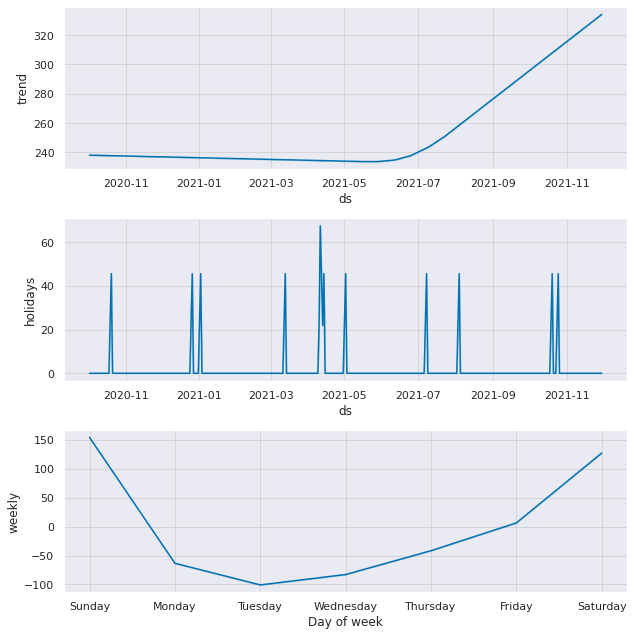

In [18]:
fig = m.plot_components(forecast)

In [19]:
# run the main forecast function on the training set and obtain metrics

forecast = forecast_by_Prophet((train_df))
error_mape = mean_absolute_percentage_error(test_df.y[-forecast_horizon:], forecast.yhat[-forecast_horizon:])
error_mae =  mean_absolute_error(test_df.y[-forecast_horizon:], forecast.yhat[-forecast_horizon:])
print("mae: " + str(error_mae) + " mape: " + str(error_mape))

/home/sitwala/linuxdevs/DSI/twist2/env/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -12.243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       676.285    0.00104255       88.7267      0.4273      0.4273      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       678.819   0.000929156       168.496   8.251e-06       0.001      219  LS failed, Hessian reset 
     199       679.418   1.37042e-05       86.8867      0.4119      0.4119      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       679.421   3.67535e-08       85.4575      0.2319           1      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/sitwala/linuxdevs/DSI/twist2/env/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/sitwala/linuxdevs/DSI/twist2/env/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


mae: 92.52881356070088 mape: 0.5075651659727368


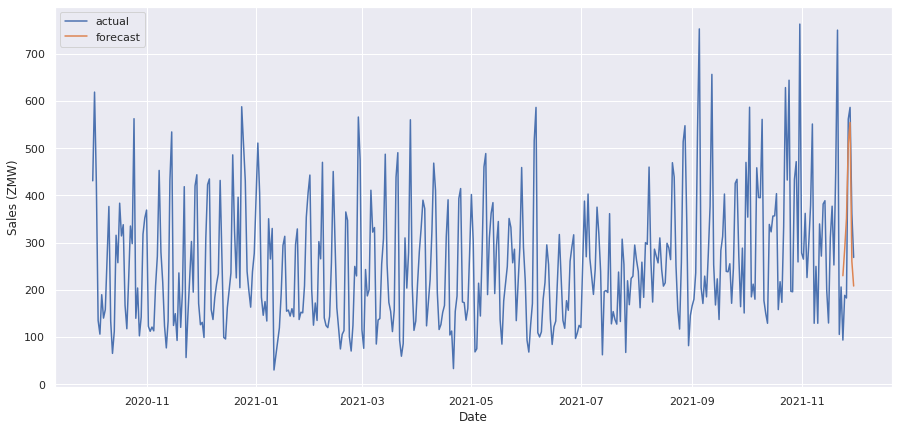

In [20]:
#plot the zoomed out forecast
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x=ts.ds, y=ts.y, label="actual")
sns.lineplot(x=forecast.ds, y=forecast.yhat, label="forecast")
plt.xlabel("Date")
plt.ylabel("Sales (ZMW)")
plt.savefig("images/zoomed_out_prophet_pred.png")


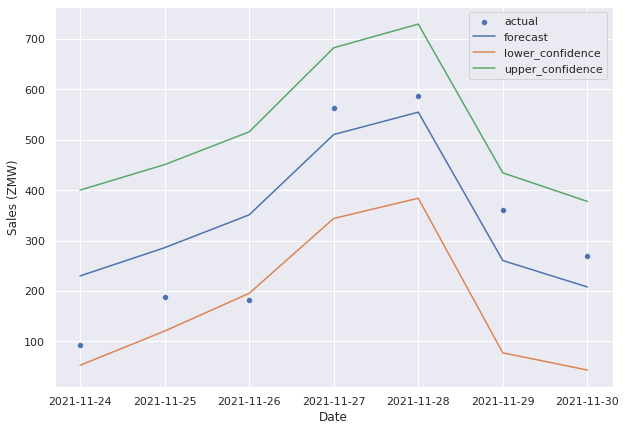

In [21]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x=ts.ds[-forecast_horizon:], y=ts.y[-forecast_horizon:], label="actual")
sns.lineplot(x=forecast.ds[-forecast_horizon:], y=forecast.yhat[-forecast_horizon:], label="forecast")
sns.lineplot(x=forecast.ds[-forecast_horizon:], y=forecast.yhat_lower[-forecast_horizon:], label="lower_confidence")
sns.lineplot(x=forecast.ds[-forecast_horizon:], y=forecast.yhat_upper[-forecast_horizon:], label="upper_confidence")
plt.xlabel("Date")
plt.ylabel("Sales (ZMW)")
plt.savefig("images/prophet_with_conf.png")


In [22]:
# Save the Model
with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)


# 3. xGBoost Modelling of Residuals

In [23]:
# Add days of the week to the dataframe

grouped_day["day_of_week"] = grouped_day['Date'].dt.strftime("%A")
grouped_day

,Date,Total,day_of_week
0,2020-10-02,431.0,Friday
1,2020-10-03,619.0,Saturday
2,2020-10-04,428.3,Sunday
3,2020-10-05,135.0,Monday
4,2020-10-06,106.0,Tuesday
...,...,...,...
413,2021-11-26,182.6,Friday
414,2021-11-27,561.8,Saturday
415,2021-11-28,586.6,Sunday
416,2021-11-29,361.3,Monday


In [24]:
# add one hot encoding for the days

encodes = pd.get_dummies(grouped_day["day_of_week"])
grouped_day2 = pd.concat([encodes,grouped_day.drop("day_of_week", axis=1)], axis=1)
grouped_day2.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Date,Total
0,1,0,0,0,0,0,0,2020-10-02,431.0
1,0,0,1,0,0,0,0,2020-10-03,619.0
2,0,0,0,1,0,0,0,2020-10-04,428.3
3,0,1,0,0,0,0,0,2020-10-05,135.0
4,0,0,0,0,0,1,0,2020-10-06,106.0


In [25]:
# create training and testing dataframe

forecast_horizon = 7 #days to forecast
train_df = grouped_day2[:-forecast_horizon]
test_df =  grouped_day2[-forecast_horizon:]
print("train",train_df.tail())
print("test",test_df.head())

train      Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
406       1       0         0       0         0        0          0   
407       0       0         1       0         0        0          0   
408       0       0         0       1         0        0          0   
409       0       1         0       0         0        0          0   
410       0       0         0       0         0        1          0   

          Date  Total  
406 2021-11-19  252.6  
407 2021-11-20  449.6  
408 2021-11-21  750.4  
409 2021-11-22  105.4  
410 2021-11-23  206.0  
test      Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
411       0       0         0       0         0        0          1   
412       0       0         0       0         1        0          0   
413       1       0         0       0         0        0          0   
414       0       0         1       0         0        0          0   
415       0       0         0       1         0        0       

In [26]:
# Can remove the last day from one hot encoding

Xtrain, ytrain = train_df[["Friday",  "Monday", "Saturday", "Sunday" , "Thursday", "Tuesday" ]], train_df.Total
Xtest, ytest = test_df[["Friday",  "Monday", "Saturday", "Sunday" , "Thursday", "Tuesday"]], test_df.Total 


In [27]:
# Fit the Model

reg = xgb.XGBRegressor(n_estimators=100)

reg.fit(Xtrain, ytrain,
        eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
        early_stopping_rounds=50,
       verbose=False)

/home/sitwala/linuxdevs/DSI/twist2/env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [28]:
# Create dataset from the prediction

data_test = test_df.copy()
data_test['number_Prediction'] = reg.predict(Xtest)
data_test['number_Prediction'] = data_test['number_Prediction'] 
data_all = pd.concat([train_df,data_test,], axis=0, sort=False)
data_all.tail()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Date,Total,number_Prediction
413,1,0,0,0,0,0,0,2021-11-26,182.6,259.838470
414,0,0,1,0,0,0,0,2021-11-27,561.8,382.774872
415,0,0,0,1,0,0,0,2021-11-28,586.6,409.221558
416,0,1,0,0,0,0,0,2021-11-29,361.3,191.399994
417,0,0,0,0,0,1,0,2021-11-30,268.6,154.462753


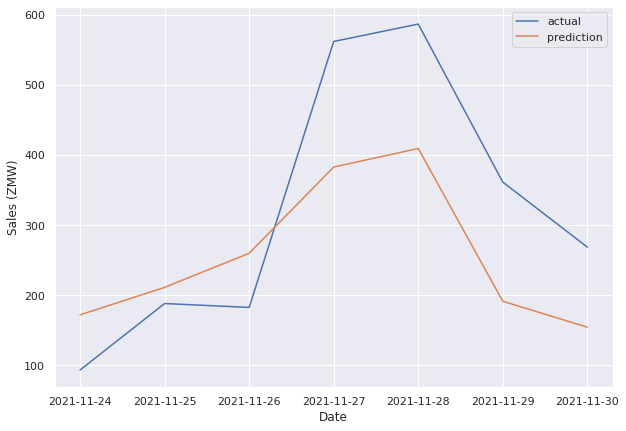

In [29]:
sns.set()
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot( x = data_all.Date[-forecast_horizon:], y= data_all.Total[-forecast_horizon:], label = "actual", ax=ax)
sns.lineplot(x= data_all.Date[-forecast_horizon:], y=data_all.number_Prediction[-forecast_horizon:], label = "prediction", ax=ax)
plt.ylabel("Sales (ZMW)")
plt.savefig("images/xgboost_pred.png")

In [30]:
error_mape = mean_absolute_percentage_error(data_all.Total[-forecast_horizon:], reg.predict(Xtest))
error_mae =  mean_absolute_error(data_all.Total[-forecast_horizon:], reg.predict(Xtest))
print("mae: " + str(error_mae) + " mape: " + str(error_mape))

mae: 117.05359017508371 mape: 0.41482646019767255


/home/sitwala/linuxdevs/DSI/twist2/env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sitwala/linuxdevs/DSI/twist2/env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


# 4. LSTM Modelling

 Reference: https://www.youtube.com/watch?v=S8tpSG6Q2H0

In [31]:
# use same train and test set as in the Prophet Model

forecast_horizon = 7 #days to forecast
x = difference(ts)
train_df_lstm = ts[:-forecast_horizon].drop("ds", axis = 1)
test_df_lstm =  ts[-forecast_horizon:].drop("ds", axis = 1)

print("train",train_df_lstm.tail())
print("test",test_df_lstm.head())

train          y
406  252.6
407  449.6
408  750.4
409  105.4
410  206.0
test          y
411   93.4
412  188.2
413  182.6
414  561.8
415  586.6


In [32]:
# Scale time-series

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df_lstm)
scaled_test = scaler.transform(test_df_lstm)

In [33]:
# define generator

n_input = len(train_df_lstm.index)-1
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [52]:
# define model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mape', metrics = "mae")

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [54]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 114.8757 - mae: 0.2758
Epoch 2/50
1/1 [==============================] - 0s 254ms/step - loss: 92.6233 - mae: 0.2223
Epoch 3/50
1/1 [==============================] - 0s 245ms/step - loss: 71.1508 - mae: 0.1708
Epoch 4/50
1/1 [==============================] - 0s 248ms/step - loss: 49.7678 - mae: 0.1195
Epoch 5/50
1/1 [==============================] - 0s 249ms/step - loss: 27.6481 - mae: 0.0664
Epoch 6/50
1/1 [==============================] - 0s 256ms/step - loss: 3.7589 - mae: 0.0090
Epoch 7/50
1/1 [==============================] - 0s 296ms/step - loss: 23.3333 - mae: 0.0560
Epoch 8/50
1/1 [==============================] - 0s 259ms/step - loss: 34.6581 - mae: 0.0832
Epoch 9/50
1/1 [==============================] - 0s 259ms/step - loss: 34.9636 - mae: 0.0839
Epoch 10/50
1/1 [==============================] - 0s 251ms/step - loss: 29.1702 - mae: 0.0700
Epoch 11/50
1/1 [==============================] - 0s 262ms/st

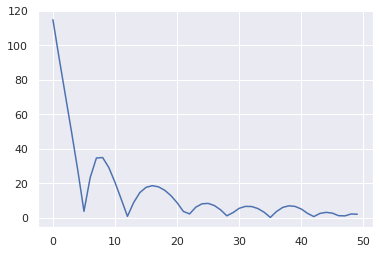

In [55]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [57]:
# run prediction for the whole forecast horizon
# Code taken from  https://www.youtube.com/watch?v=S8tpSG6Q2H0

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_df_lstm.index)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [58]:
test_predictions2 =  scaler.inverse_transform(test_predictions)
predictions = np.concatenate(test_predictions2).ravel().tolist()
predictions

[204.09832080602646,
 196.83680840134622,
 188.08377522826194,
 179.03235486745834,
 170.32703348994255,
 162.29072610139846,
 155.05954297184945]

In [59]:

# create dataframe with test and train set

output_df = pd.DataFrame({"ds": test_df["Date"] , "actual": test_df_lstm["y"], "predictions": predictions})
output_df.head()

,ds,actual,predictions
411,2021-11-24,93.4,204.098321
412,2021-11-25,188.2,196.836808
413,2021-11-26,182.6,188.083775
414,2021-11-27,561.8,179.032355
415,2021-11-28,586.6,170.327033


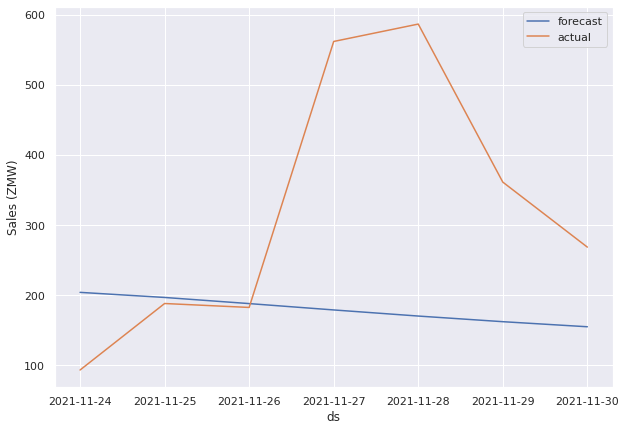

In [60]:
sns.set()
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot( x =  output_df.ds, y= output_df.predictions , label = "forecast", ax=ax)
sns.lineplot(x= output_df.ds, y= output_df.actual, label = "actual", ax=ax)
plt.ylabel("Sales (ZMW)")
plt.savefig("images/lstm_pred.png")

In [61]:
error_mape = mean_absolute_percentage_error(output_df.actual,  output_df.predictions )
error_mae =  mean_absolute_error(output_df.actual,  output_df.predictions )
print("mae: " + str(error_mae) + " mape: " + str(error_mape))

mae: 176.62989242928367 mape: 0.5179453131762796
